Sources used
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
* https://datascience.stackexchange.com/questions/65979/what-is-the-correct-way-to-call-keras-flow-from-directory-method
* https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
* https://github.com/keras-team/keras/issues/5862#issuecomment-647559571
* https://keras.io/api/preprocessing/image/
* https://stackoverflow.com/questions/57092637/how-to-fit-keras-imagedatagenerator-for-large-data-sets-using-batches

In [1]:
import sys
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install numpy

In [2]:
import os
import time
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
import tensorflow as tf

In [3]:
start = time.time()

In [4]:
# define constants
ORIGINAL_PARENT_DIR = './FRUIT-16K' # enter path to original dataset
PREPROCESSED_PARENT_DIR = './FRUIT-16K-PREPROCESSED' # enter path to folder where you want the preprocessed data to go (code will create it)

CLASSES = []
for directory in os.listdir(ORIGINAL_PARENT_DIR):
    path = os.path.join(ORIGINAL_PARENT_DIR, directory)
    if os.path.isdir(path) and not directory.startswith('.'):
        CLASSES.append(directory)
print(CLASSES)

# define hyper-parameters
BATCH_SIZE = 256
IMAGE_HEIGHT = 56
IMAGE_WIDTH = 56
SEED = 42
TEST_SIZE = 0.2

['F_Banana', 'F_Lemon', 'F_Lulo', 'F_Mango', 'F_Orange', 'F_Strawberry', 'F_Tamarillo', 'F_Tomato', 'S_Banana', 'S_Lemon', 'S_Lulo', 'S_Mango', 'S_Orange', 'S_Strawberry', 'S_Tamarillo', 'S_Tomato']


In [5]:
def read_image(path):
    img = load_img(path, target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    img_arr = img_to_array(img)
    return img_arr

def get_images_df(path):
    # walk through the path and create a dataframe
    # that has one column for the path to the image
    # and the other with the class name
    images_data = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.startswith('.'):
                # add to dict [ image | class_name ]
                class_name = root.split(os.sep)[-1]
                image_path = os.path.join(root, file)
                images_data.append({
                    'image_path': image_path,
                    'class': class_name
                })
    df = pd.DataFrame(images_data)
    
    return df

def create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path): 
    # create the train and test folders
    train_path = os.path.join(save_path, 'train')
    test_path = os.path.join(save_path, 'test')
    os.mkdir(train_path)
    os.mkdir(test_path)
        
    # for each class, make a subfolder
    for class_name in classes:
        os.mkdir(os.path.join(train_path, class_name))
        os.mkdir(os.path.join(test_path, class_name))
    
    # transfer files from dataframe image path to the appropriate
    # subfolder in save_path (sub folders based on class name)
    # also create x_train_final and x_test_final which will
    # store pixels of image
    x_train_final = []
    x_test_final = []
    for x_val, y_val in zip(x_train, y_train):
        new_path = os.path.join(train_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_train_final.append(img_arr)
    for x_val, y_val in zip(x_test, y_test):
        new_path = os.path.join(test_path, y_val)
        shutil.copy(x_val, new_path)
        filename = x_val.split(os.sep)[-1]
        img_arr = read_image(os.path.join(new_path, filename))
        x_test_final.append(img_arr)
    
    return np.asarray(x_train_final), np.asarray(x_test_final), y_train, y_test
        
def transfer_data(original_dir, new_dir, classes, test_size):
    # get the images as a dataframe
    # this dataframe has two columns, one with
    # the path to the image in original_dir and one with
    # the class name
    original_df = get_images_df(original_dir)
    
    # split the df into train and test
    x, y = original_df['image_path'], original_df['class']
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 42, test_size = test_size)
    
    # create the new_dir folder
    if os.path.exists(new_dir):
        shutil.rmtree(new_dir)
    os.mkdir(new_dir)
    
    # transfer all the data from original_df to new_dir
    # with the appropriate formatting and get back the
    # split with the x arrays having the pixels associated
    # with the images and the y arrays having the label
    x_train, x_test, y_train, y_test = create_train_test_data(x_train, x_test, y_train, y_test, classes, save_path = new_dir)
    
    return x_train, x_test, y_train, y_test

In [6]:
x_train, x_test, y_train, y_test = transfer_data(ORIGINAL_PARENT_DIR, PREPROCESSED_PARENT_DIR, classes = CLASSES, test_size = TEST_SIZE)

In [7]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3196077544174256490
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7803502592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10763098094791238434
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [8]:
# augment and preprocess the training data
#train_image_data_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input,rescale = 1./255, rotation_range=30,
                                          zoom_range=0.15, width_shift_range=0.2,
                                          height_shift_range=0.2, shear_range=0.15,
                                          horizontal_flip=True, fill_mode="nearest", validation_split = 0.2)

#valGenerator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

print("done with train image generator")

# fit the train_image_data_generator to the train set
# only run this line of code if featurewise_center or featurewise_std_normalization or zca_whitening set to True
print(len(x_train))
#train_image_data_generator.fit(x_train)
#print("done with fit")

# do NOT augment the testing data
test_image_data_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, rescale = 1./255)

# create the training generator and the testing generator from their respective folders
train_generator = train_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'train'), 
                                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                                 classes = CLASSES, batch_size = BATCH_SIZE, 
                                                                 shuffle = True, seed = SEED, subset='training')

validation_generator = train_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'train'), 
                                                                 target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                                 classes = CLASSES, batch_size = BATCH_SIZE, 
                                                                 shuffle = True, seed = SEED, subset='validation')


#print(PREPROCESSED_PARENT_DIR)


test_generator = test_image_data_generator.flow_from_directory(os.path.join(PREPROCESSED_PARENT_DIR, 'test'), 
                                                               target_size = (IMAGE_HEIGHT, IMAGE_WIDTH), 
                                                               classes = CLASSES, batch_size = BATCH_SIZE, 
                                                               shuffle = True, seed = SEED)

print("done with flow")

done with train image generator
12800
Found 10247 images belonging to 16 classes.
Found 2553 images belonging to 16 classes.
Found 3200 images belonging to 16 classes.
done with flow


In [9]:
#end = time.time()

In [10]:
#print(end - start)

A few potentially useful links/notes for the ML team
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator (check out the Example of using `.flow_from_directory(directory)` section) for how (I think) you can use the fit function with generators)
* You can access the mapping from class to indices through `train_generator.class_indices` or `train_generator.class_indices`
* https://stackoverflow.com/questions/61864244/how-to-avoid-augmenting-data-in-validation-split-of-keras-imagedatagenerator
* https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/
* https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c

In [11]:
# verify that the class index mapping are the same (should always be the case)
print(test_generator.class_indices == train_generator.class_indices)
print(train_generator.class_indices)
print(len(train_generator.class_indices))

True
{'F_Banana': 0, 'F_Lemon': 1, 'F_Lulo': 2, 'F_Mango': 3, 'F_Orange': 4, 'F_Strawberry': 5, 'F_Tamarillo': 6, 'F_Tomato': 7, 'S_Banana': 8, 'S_Lemon': 9, 'S_Lulo': 10, 'S_Mango': 11, 'S_Orange': 12, 'S_Strawberry': 13, 'S_Tamarillo': 14, 'S_Tomato': 15}
16


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


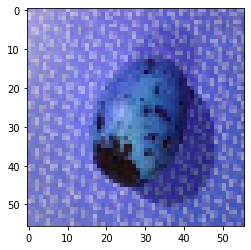

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


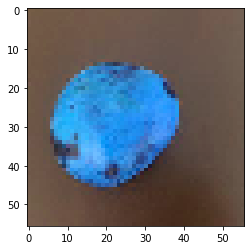

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


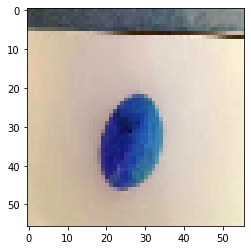

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


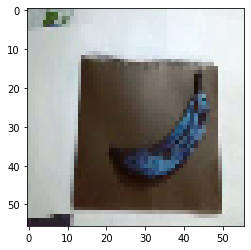

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


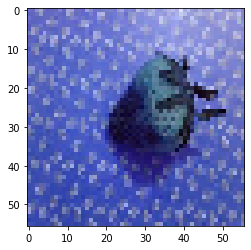

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


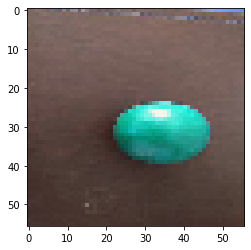

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


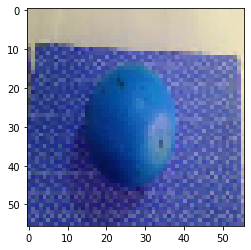

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


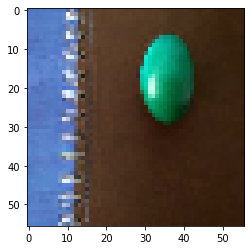

[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


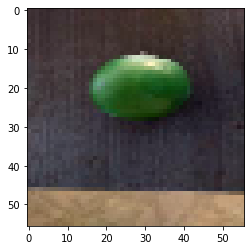

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


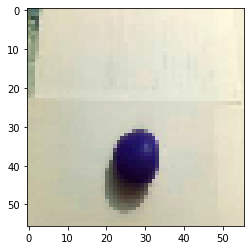

In [12]:
for _ in range(10):
    img, label = test_generator.next()
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


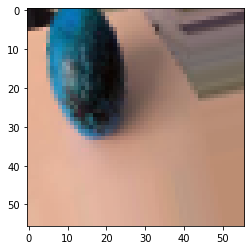

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


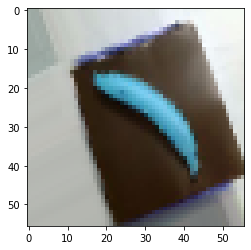

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


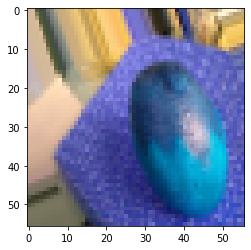

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


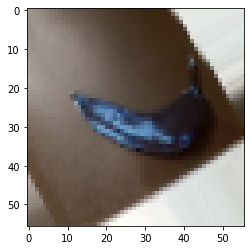

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


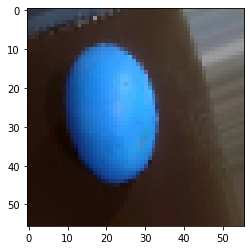

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


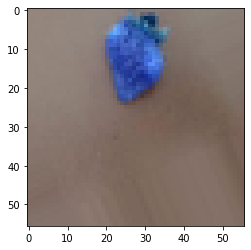

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


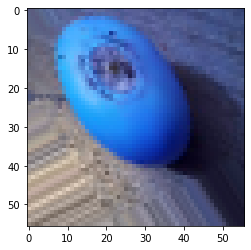

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


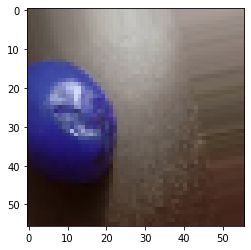

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


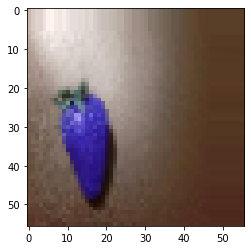

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


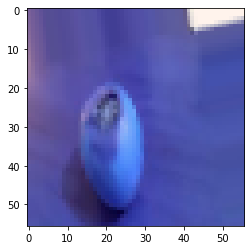

In [13]:
for _ in range(10):
    img, label = validation_generator.next()
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


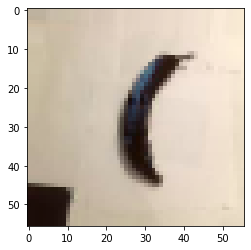

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


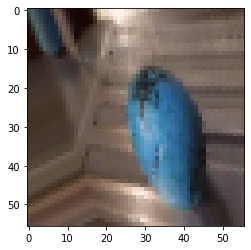

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


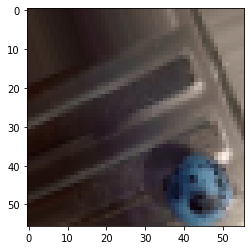

(256, 56, 56, 3)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


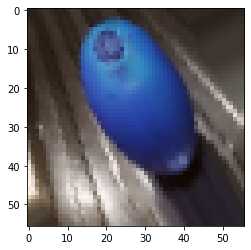

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


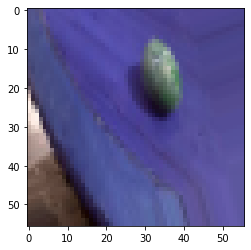

(256, 56, 56, 3)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


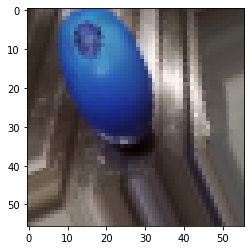

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


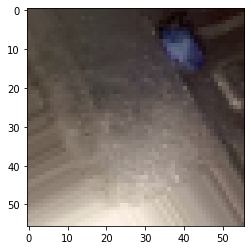

(256, 56, 56, 3)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


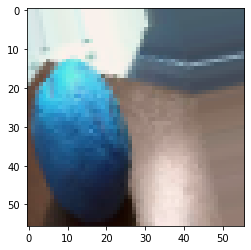

(256, 56, 56, 3)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


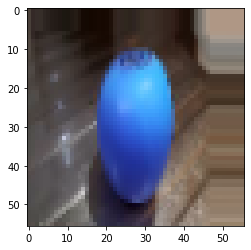

(256, 56, 56, 3)
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


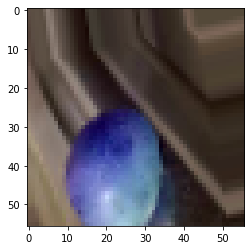

In [14]:
for _ in range(10):
    img, label = train_generator.next()
    print(img.shape)
    print(label[0])
    plt.imshow(array_to_img(img[0]))
    plt.show()

In [15]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10499059726922568739
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7803502592
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 3169766659351981608
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [16]:
import sys
!{sys.executable} -m pip install keras-tuner --upgrade

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import History 
import keras_tuner as kt


model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(56,56,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    

#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = History()

model.fit(train_generator,
          batch_size=256,
          epochs=27,
          verbose=1,
          validation_data=validation_generator,
          callbacks=[history])

score = model.evaluate(test_generator, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/27
41/41 [==============================] - 16s 375ms/step - loss: 2.3452 - accuracy: 0.2409 - val_loss: 2.1888 - val_accuracy: 0.2934
Epoch 2/27
41/41 [==============================] - 15s 364ms/step - loss: 1.7736 - accuracy: 0.4154 - val_loss: 1.8167 - val_accuracy: 0.3866
Epoch 3/27
41/41 [==============================] - 15s 362ms/step - loss: 1.4617 - accuracy: 0.5146 - val_loss: 1.5681 - val_accuracy: 0.4736
Epoch 4/27
41/41 [==============================] - 15s 367ms/step - loss: 1.2116 - accuracy: 0.5939 - val_loss: 1.4095 - val_accuracy: 0.5296
Epoch 5/27
41/41 [==============================] - 15s 363ms/step - loss: 1.0468 - accuracy: 0.6406 - val_loss: 1.3249 - val_accuracy: 0.5535
Epoch 6/27
41/41 [==============================] - 15s 363ms/step - loss: 0.9385 - accuracy: 0.6794 - val_loss: 1.2113 - val_accuracy: 0.5922
Epoch 7/27
41/41 [==============================] - 15s 368ms/step - loss: 0.8482 - accuracy: 0.7108 - val_loss: 1.1375 - val_accuracy: 0.6020

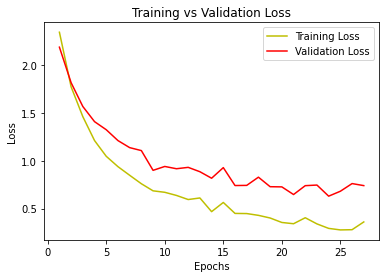

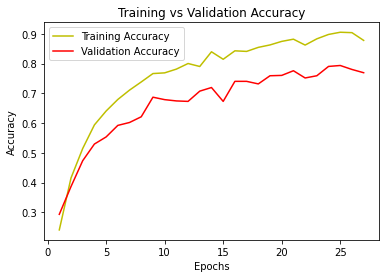

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(loss)+1)
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [43]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(56,56,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    

#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history1 = History()

model.fit(train_generator,
          batch_size=256,
          epochs=27,
          verbose=1,
          validation_data=validation_generator,
          callbacks=[history1])

score = model.evaluate(test_generator, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/27
41/41 [==============================] - 16s 372ms/step - loss: 2.5425 - accuracy: 0.1682 - val_loss: 2.3735 - val_accuracy: 0.2385
Epoch 2/27
41/41 [==============================] - 15s 358ms/step - loss: 2.0028 - accuracy: 0.3417 - val_loss: 1.9426 - val_accuracy: 0.3897
Epoch 3/27
41/41 [==============================] - 15s 372ms/step - loss: 1.6041 - accuracy: 0.4655 - val_loss: 1.6310 - val_accuracy: 0.4736
Epoch 4/27
41/41 [==============================] - 15s 372ms/step - loss: 1.3528 - accuracy: 0.5507 - val_loss: 1.5002 - val_accuracy: 0.5041
Epoch 5/27
41/41 [==============================] - 15s 366ms/step - loss: 1.2268 - accuracy: 0.5854 - val_loss: 1.3323 - val_accuracy: 0.5127
Epoch 6/27
41/41 [==============================] - 15s 367ms/step - loss: 1.0660 - accuracy: 0.6339 - val_loss: 1.2615 - val_accuracy: 0.5488
Epoch 7/27
41/41 [==============================] - 15s 369ms/step - loss: 0.9237 - accuracy: 0.6785 - val_loss: 1.1219 - val_accuracy: 0.6044

In [44]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(9, 9),
                     activation='relu',
                     input_shape=(56,56,3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.20))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])
    

#earlyStop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history2 = History()

model.fit(train_generator,
          batch_size=256,
          epochs=27,
          verbose=1,
          validation_data=validation_generator,
          callbacks=[history2])

score = model.evaluate(test_generator, verbose=0)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/27
41/41 [==============================] - 16s 376ms/step - loss: 2.6417 - accuracy: 0.1414 - val_loss: 2.5617 - val_accuracy: 0.2370
Epoch 2/27
41/41 [==============================] - 15s 366ms/step - loss: 2.1532 - accuracy: 0.3153 - val_loss: 2.2389 - val_accuracy: 0.2965
Epoch 3/27
41/41 [==============================] - 15s 372ms/step - loss: 1.7722 - accuracy: 0.4239 - val_loss: 1.9499 - val_accuracy: 0.3737
Epoch 4/27
41/41 [==============================] - 15s 364ms/step - loss: 1.5250 - accuracy: 0.4962 - val_loss: 1.6732 - val_accuracy: 0.4207
Epoch 5/27
41/41 [==============================] - 15s 364ms/step - loss: 1.3622 - accuracy: 0.5393 - val_loss: 1.4902 - val_accuracy: 0.4508
Epoch 6/27
41/41 [==============================] - 15s 370ms/step - loss: 1.2224 - accuracy: 0.5874 - val_loss: 1.4632 - val_accuracy: 0.4998
Epoch 7/27
41/41 [==============================] - 15s 362ms/step - loss: 1.0761 - accuracy: 0.6253 - val_loss: 1.3827 - val_accuracy: 0.5139

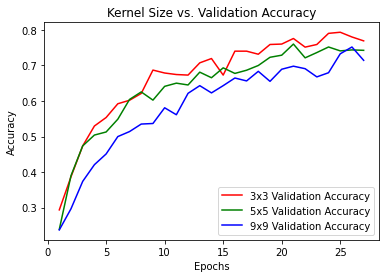

In [49]:
val_acc1 = history.history['val_accuracy']
val_acc2 = history1.history['val_accuracy']
val_acc3 = history2.history['val_accuracy']

plt.plot(epochs, val_acc1, 'r', label = '3x3 Validation Accuracy')

plt.plot(epochs, val_acc2, 'g', label = '5x5 Validation Accuracy')

plt.plot(epochs, val_acc3, 'b', label = '9x9 Validation Accuracy')

plt.title('Kernel Size vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()